# DnD Monster Data Wrangling


## Importation

In [346]:
from math import pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from bioinfokit.analys import stat
%matplotlib inline

monster_df = pd.read_csv('../data/raw/Monster_Data_RAW.csv')

monster_df.head()

,Unnamed: 0,Monster Name,Size,Type,Alignment,Traits,Damage Resistances,Monster Tags:,Mythic Actions,Reactions,...,Proficiency Bonus,STR,DEX,CON,INT,WIS,CHA,Actions,Legendary Actions,Environment:
0,0,Adult Green Dragon,Huge,['dragon'],lawful evil,['Amphibious. The dragon can breathe air and w...,NaN,NaN,NaN,NaN,...,5,23,12,21,18,15,17,['Multiattack. The dragon can use its Frightfu...,"[""The dragon can take 3 legendary actions, cho...",['Forest']
1,1,Adult Silver Dragon,Huge,['dragon'],lawful good,['Legendary Resistance (3/Day). If the dragon ...,NaN,NaN,NaN,NaN,...,5,27,10,25,16,13,21,['Multiattack. The dragon can use its Frightfu...,"[""The dragon can take 3 legendary actions, cho...","['Mountain', 'Urban']"
2,2,Adult White Dragon,Huge,['dragon'],chaotic evil,"[""Ice Walk. The dragon can move across and cli...",NaN,NaN,NaN,NaN,...,5,22,10,22,8,12,12,['Multiattack. The dragon can use its Frightfu...,"[""The dragon can take 3 legendary actions, cho...",['Arctic']
3,3,Air Elemental,Large,['elemental'],neutral,"[""Air Form. The elemental can enter a hostile ...","Lightning, Thunder; Bludgeoning, Piercing, and...",NaN,NaN,NaN,...,3,14,20,14,6,10,6,['Multiattack. The elemental makes two slam at...,NaN,"['Desert', 'Mountain']"
4,4,Ape,Medium,['beast'],unaligned,[nan],NaN,['Misc Creature'],NaN,NaN,...,2,16,14,14,6,12,7,['Multiattack. The ape makes two fist attacks....,NaN,['Forest']


In [347]:
#no monsters with mythic actions, not interested in skills or tags (dup for type) and unamed?
monster_df.drop(columns = {'Unnamed: 0','Mythic Actions','Monster Tags:', "Skills",'Source','Languages',"Senses"}, inplace = True, axis = 1)

#Remove the XP attached to CR & turn challenge rating into a float
monster_df["Challenge"] = monster_df["Challenge"].str.split().str[0]
for number, indx in zip(monster_df["Challenge"], monster_df.index):
    if "/" in number:
       new_CR = pd.eval(number)
    else:
        new_CR = pd.to_numeric(number)
    monster_df.loc[indx,'Challenge'] = new_CR
monster_df["Challenge"] = pd.to_numeric(monster_df["Challenge"])

#rename columns
monster_df.rename(columns={"Environment:":"Environment"}, inplace=True)

#consolidate types into categories (beast, dragon, monstrosity, homanoid, undead, elemental, etc.)
for indx,Type in enumerate(monster_df['Type']):
    monster_df.loc[indx,"Type"] = Type.split(",")[0].strip("[']")


monster_df["Environment"].fillna("None",inplace=True)


#All lists columns are actually strings!
for i,j in enumerate(monster_df["Environment"]):
   print("list",i,"is",type(j))

# Scrape Attack Bonus out of the Action feature
monster_df['Attack Bonus'] = ""
for indx, action in enumerate(monster_df['Actions']):
    try:
        found = re.search("\+(.+?) to hit", action).group(0)
        monster_df.loc[indx,'Attack Bonus'] = int(found.split()[0].lstrip('+'))
    except:
        monster_df.loc[indx,'Attack Bonus'] = 0

#Scrape Spell Attack Bonus out of Traits for  Spellcasters
monster_df['Spell Bonus'] = ""
for indx, trait in enumerate(monster_df['Traits']):
    try:
        found = re.search("\+(.+?) to hit", trait).group(0)
        monster_df.loc[indx,'Spell Bonus'] = int(found.split()[0].lstrip('+'))
    except:
        monster_df.loc[indx,'Spell Bonus'] = 0

#Scrape Spell Save DC out of Traits for Spellcasters
monster_df['Spell Save DC'] = ""
for indx, trait in enumerate(monster_df['Traits']):
    try:
        found = re.search("spell save DC [0-9]+", trait).group(0)
        monster_df.loc[indx,'Spell Save DC'] = int(found.split()[-1])
    except:
        monster_df.loc[indx,'Spell Save DC'] = 0

#evaluate string and turn into lists
column_lists = ["Environment", "Reactions", "Actions", "Legendary Actions"]
for columns in column_lists:
    monster_df[columns].fillna("None",inplace=True)
    monster_df[columns] = monster_df[columns].apply(ast.literal_eval)

#"Damage Resistances","Damage Vulnerabilities", "Damage Immunities", have wonky typing due to semicolon
# Traits, Condition immunities, saving throws create type error

#check that they are lists
for i,j in enumerate(monster_df["Environment"]):
   print("list",i,"is",type(j))

#create dummy variables for envinroment, which includes the list for variables
dummies = pd.get_dummies(monster_df['Environment'].explode()).reset_index().groupby(['index']).sum()
monster_df = pd.concat([monster_df,dummies], axis=1)

list 0 is <class 'str'>
list 1 is <class 'str'>
list 2 is <class 'str'>
list 3 is <class 'str'>
list 4 is <class 'str'>
list 5 is <class 'str'>
list 6 is <class 'str'>
list 7 is <class 'str'>
list 8 is <class 'str'>
list 9 is <class 'str'>
list 10 is <class 'str'>
list 11 is <class 'str'>
list 12 is <class 'str'>
list 13 is <class 'str'>
list 14 is <class 'str'>
list 15 is <class 'str'>
list 16 is <class 'str'>
list 17 is <class 'str'>
list 18 is <class 'str'>
list 19 is <class 'str'>
list 20 is <class 'str'>
list 21 is <class 'str'>
list 22 is <class 'str'>
list 23 is <class 'str'>
list 24 is <class 'str'>
list 25 is <class 'str'>
list 26 is <class 'str'>
list 27 is <class 'str'>
list 28 is <class 'str'>
list 29 is <class 'str'>
list 30 is <class 'str'>
list 31 is <class 'str'>
list 32 is <class 'str'>
list 33 is <class 'str'>
list 34 is <class 'str'>
list 35 is <class 'str'>
list 36 is <class 'str'>
list 37 is <class 'str'>
list 38 is <class 'str'>
list 39 is <class 'str'>
list 40 is

In [357]:
monster_short = monster_df.iloc[:,0:28]
monster_short[monster_short["Spell Save DC"]>0]

,Monster Name,Size,Type,Alignment,Traits,Damage Resistances,Reactions,Armor Class,Hit Points,Speed,...,CON,INT,WIS,CHA,Actions,Legendary Actions,Environment,Attack Bonus,Spell Bonus,Spell Save DC
14,Couatl,Medium,celestial,lawful good,"[""Innate Spellcasting. The couatl's spellcasti...",Radiant,None,19,97,"30 ft., fly 90 ft.",...,17,18,20,18,"[Bite. Melee Weapon Attack: +8 to hit, reach 5...",None,"[Desert, Forest, Grassland, Urban]",8,0,14
19,Deva,Medium,celestial,lawful good,"[""Angelic Weapons. The deva's weapon attacks a...","Radiant; Bludgeoning, Piercing, and Slashing f...",None,17,136,"30 ft., fly 90 ft.",...,18,17,20,20,[Multiattack. The deva makes two melee attacks...,None,None,8,0,17
24,Dryad,Medium,fey,neutral,"[""Innate Spellcasting. The dryad's innate spel...",NaN,None,11,22,30 ft.,...,11,14,15,18,[Club. Melee Weapon Attack: +2 to hit (+6 to h...,None,[Forest],2,0,14
27,Efreeti,Large,elemental,lawful evil,"['Elemental Demise. If the efreeti dies, its b...",NaN,None,17,200,"40 ft., fly 60 ft.",...,24,16,15,16,[Multiattack. The efreeti makes two scimitar a...,None,[Desert],10,7,15
28,Faerie Dragon (Older),Tiny,dragon,chaotic good,"['Superior Invisibility. As a bonus action, th...",NaN,None,15,14,"10 ft., fly 60 ft.",...,13,14,12,16,"[Bite. Melee Weapon Attack: +7 to hit, reach 5...",None,[Forest],7,0,13
40,Guardian Naga,Large,monstrosity,lawful good,"['Rejuvenation. If it dies, the naga returns t...",NaN,None,18,127,40 ft.,...,16,16,19,18,"[Bite. Melee Weapon Attack: +8 to hit, reach 1...",None,"[Desert, Forest]",8,8,16
46,Lamia,Large,monstrosity,chaotic evil,"[""Innate Spellcasting. The lamia's innate spel...",NaN,None,13,97,30 ft.,...,15,14,15,16,[Multiattack. The lamia makes two attacks: one...,None,[Desert],5,0,13
48,Mage,Medium,humanoid,any alignment,['Spellcasting. The mage is a 9th-level spellc...,NaN,None,12,40,30 ft.,...,11,17,12,11,[Dagger. Melee or Ranged Weapon Attack: +5 to ...,None,[Urban],5,6,14
49,Magma Mephit,Small,elemental,neutral evil,"['Death Burst. When the mephit dies, it explod...",NaN,None,11,22,"30 ft., fly 30 ft.",...,12,7,10,10,"[Claws. Melee Weapon Attack: +3 to hit, reach ...",None,[Underdark],3,0,10
54,Mummy Lord,Medium,undead,lawful evil,['Magic Resistance. The mummy lord has advanta...,NaN,None,17,97,20 ft.,...,17,11,18,16,[Multiattack. The mummy can use its Dreadful G...,"[The mummy lord can take 3 legendary actions, ...",[Desert],9,9,17


In [337]:

#Scrape Spell Save DC out of Traits for Spellcasters
monster_df['Spell Save DC'] = ""
for indx, trait in enumerate(monster_df['Traits']):
    try:
        found = re.search("spell save DC [0-9] ", trait).group(0)
        print(found.split()[-1])
    except:
        continue

In [336]:
monster_df['Spell Save DC'] = ""
for indx, trait in enumerate(monster_df['Traits']):
    try:
        print(re.search("spell save DC or", trait).group(0))
        print(indx,trait)
    except:
        continue

spell save DC or
63 ["Antimagic Susceptibility. The rug is incapacitated while in the area of an antimagic field. If targeted by dispel magic, the rug must succeed on a Constitution saving throw against the caster's spell save DC or fall unconscious for 1 minute.", 'Damage Transfer. While it is grappling a creature, the rug takes only half the damage dealt to it, and the creature grappled by the rug takes the other half.', 'False Appearance. While the rug remains motionless, it is indistinguishable from a normal rug.']
spell save DC or
102 ["Antimagic Susceptibility. The knife is incapacitated while in the area of an antimagic field. If targeted by dispel magic, the knife must succeed on a Constitution saving throw against the caster's spell save DC or fall unconscious for 1 minute.", "False Appearance. While the knife remains motionless and isn't flying, it is indistinguishable from a normal knife."]
spell save DC or
172 ["Antimagic Susceptibility. The sword is incapacitated while in 

In [330]:
monster_df['Spell Save DC'] = ""
for indx, trait in enumerate(monster_df['Traits']):
    try:
        print(re.findall("spell save DC [0-9]+", trait))
        #monster_df.loc[indx,'Spell Save DC'] = int(found.split()[)
    except:
        continue

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['spell save DC 14']
[]
[]
[]
[]
['spell save DC 17']
[]
[]
[]
[]
['spell save DC 14']
[]
[]
['spell save DC 15']
['spell save DC 13']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['spell save DC 16']
[]
[]
[]
[]
[]
['spell save DC 13']
[]
['spell save DC 14']
['spell save DC 10']
[]
[]
[]
[]
['spell save DC 17']
['spell save DC 14']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['spell save DC 25']
[]
[]
['spell save DC 14']
[]
[]
[]
['spell save DC 17']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['spell save DC 17']
[]
[]
[]
[]
[]
[]
['spell save DC 11']
[]
['spell save DC 12']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['spell save DC 12']
[]
[]
['spell save DC 16']
['spell save DC 20']
[]
[]
[]
[]
[]
['spell save DC 21']
['spell save DC 20']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['spell save DC 17']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['spell save DC 13']
[]
[]
['spell save DC 18']
[

[Text(0, 0, '2'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7'),
 Text(6, 0, '9')]

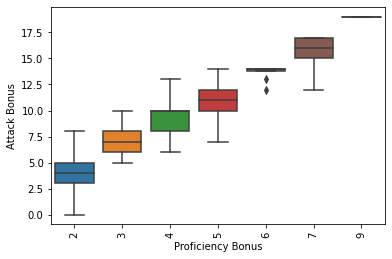

In [223]:
ax = sns.boxplot(x="Proficiency Bonus", y= "Attack Bonus", data=monster_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
#Checking for Null Values
monster_df.columns[monster_df.isna().any()].tolist()

#Damage Resistances,  Reactions, Saving Throws, Damage Vulnerabilities, Damage Immunities, Condition Immunities, Actions, Legendary Actions, Environment
#These are all monsters that just don't have these optional stats: either turn to "none", alth

#Curious that some monsters don't have actions...
monster_df[monster_df["Actions"].isna()]
#seahorse, frog make sense, also skrieker is just a mushroom. This is cool to know


In [60]:
monster_df['Actions'].explode().values

array(['Multiattack. The dragon can use its Frightful Presence. It then makes three attacks: one with its bite and two with its claws.',
       'Bite. Melee Weapon Attack: +11 to hit, reach 10 ft., one target. Hit: 17 (2d10 + 6) piercing damage plus 7 (2d6) poison damage.',
       'Claw. Melee Weapon Attack: +11 to hit, reach 5 ft., one target. Hit: 13 (2d6 + 6) slashing damage.',
       'Tail. Melee Weapon Attack: +11 to hit, reach 15 ft., one target. Hit: 15 (2d8 + 6) bludgeoning damage.',
       "Frightful Presence. Each creature of the dragon's choice that is within 120 feet of the dragon and aware of it must succeed on a DC 16 Wisdom saving throw or become frightened for 1 minute. A creature can repeat the saving throw at the end of each of its turns, ending the effect on itself on a success. If a creature's saving throw is successful or the effect ends for it, the creature is immune to the dragon's Frightful Presence for the next 24 hours.",
       'Poison Breath (Recharge 5–6). 

In [ ]:
# Reactions
#create dummy variables for envinroment, which includes the list for variables
dummies = pd.get_dummies(monster_df['Environment'].explode(),dummy_na=True).reset_index().groupby(['index']).sum()
monster_df = pd.concat([monster_df,dummies], axis=1)

list

In [169]:
# 123 Legendary Actions
# 17 Reactions
# 967 Actions

monster_df['Attack Bonus']

0       
1       
2       
3       
4       
      ..
343     
344     
345     
346     
347     
Name: Attack Bonus, Length: 348, dtype: object

In [ ]:
ax = sns.boxplot(x="Environment", y= "Hit Points",data=monster_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)